# Laoding Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:

import scipy.io as sio
mat_file_path = '/content/drive/My Drive/Dr. Faghih/ImpulseInputImpulseResponseOutputMultiRateSystem.mat'
Data = sio.loadmat(mat_file_path,squeeze_me=True)

print(Data.keys())
u=Data['u']
tu=Data['tu']
y=Data['y']
ty=Data['ty']

dict_keys(['__header__', '__version__', '__globals__', 'u', 'tu', 'ty', 'y'])


In [10]:
print(u.shape)
print(tu.shape)
print(y.shape)
print(ty.shape)

(820,)
(820,)
(165,)
(165,)


# Plot Inputs

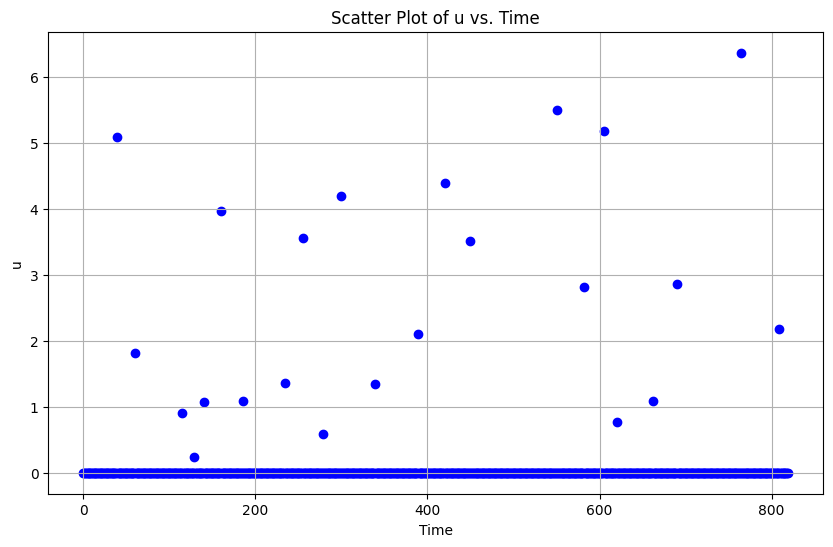

In [75]:

import matplotlib.pyplot as plt

uT = u.transpose()
tus=tu/1000;
# scatter plot u
plt.figure(figsize=(10, 6))
plt.scatter(tus, uT, marker='o', color='b', label='u')
plt.xlabel('Time')
plt.ylabel('u')
plt.title('Scatter Plot of u vs. Time')
plt.grid(True)
plt.show()



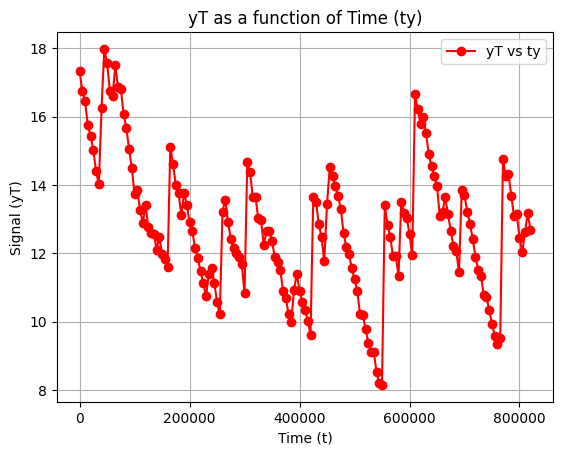

In [76]:

ty_s = ty / 1000
yT = y.transpose()
plt.plot(ty, yT, marker='o', linestyle='-', color='r')

plt.xlabel('Time (t)')
plt.ylabel('Signal (yT)')
plt.title('yT as a function of Time (ty)')

plt.grid(True)
plt.legend(['yT vs ty'])

# Display the plot
plt.show()

# Deconvolution Problem

In this part we have defined a midel baased on the stochastic differential equation model of diurnal cortisol patterns. (Deconvolution of Serum Cortisol Levels by Using Compressed Sensing, 2014, Rose T. Faghih)

In [51]:
# Modeling of cortisol concentration of Adrenal Glands (x1) and cortisol concentration of Serum (x2)
import numpy as np


# DIfferential equation (1) - Adrenal Glands
def DEQ1(u, theta1):
    x1 = np.zeros(len(u))
    for t, u_t in enumerate(u):
        if t < len(x1) - 1:
            x1[t + 1] = x1[t] - theta1 * x1[t] + u_t
    return x1



# DIfferential equation (2) - Serum
def DEQ2(y, x1, theta1, theta2):
  x2=np.zeros(len(x1)) # Changed: Initialize with the same size as x1
  x2[0] = y[0]  # Set initial condition

  for t in range(1, len(x1)): # Changed: Updated range to avoid index error
    x2[t] = x2[t - 1] + (theta1 * x1[t - 1]) - (theta2 * x2[t - 1])  # Update x2

  return x2


# Estimation of Observed serum cortisol level based on model output (x2)
def Estimation(x2, ty, tu):
  y_est = np.interp(ty, tu, x2)
  return y_est



 **Then we have to face an optimization problem. Every Optimization problem needs an objective function to do the optimization by minimizing that function. In our problem: \\
A) What variables we want to optimize? Θ1 and Θ2 \\
B) What is our objective function? Least square error between Original y and estimated**

In [52]:
def objective(OptimizedParameters, u, y, tu, ty):
  theta1 = OptimizedParameters[0]
  theta2 = OptimizedParameters[1]
  x1 = DEQ1(u, theta1)
  X2 = DEQ2(y, x1, theta1, theta2)
  y_est = Estimation(X2, ty, tu)
  return np.sum(np.power(y - y_est, 2))

In [70]:
# Initial values for Theta1 and Theta2
initial_guess = [0.1, 0.05]
# Using L-BFGS-B Minimizing method
result = minimize(objective, initial_guess, args=(u, y, tu, ty), method='L-BFGS-B', bounds=[(1e-6, None), (1e-6, None)])

theta1_est, theta2_est = result.x
objective((theta1_est, theta2_est), u, y, tu, ty)

18.51430247414958

**Based on the optimization process the final value of theta1 is 0.5943 and final value of theta2 is 0.0063**

In [71]:
from scipy.optimize import minimize

# Example using L-BFGS-B with bounds
result = minimize(objective, initial_guess, args=(u, y, tu, ty), method='L-BFGS-B', bounds=[(1e-6, None), (1e-6, None)])

theta1_est, theta2_est = result.x
print(f'Estimated theta1: {theta1_est:.4f}')
print(f'Estimated theta2: {theta2_est:.4f}')


Estimated theta1: 0.5943
Estimated theta2: 0.0063


**Now we want to see what we have done! We pass the optimized parameters thata1 and theta2 to the differential models we defined before. Then we can find an estimated y that shows how well we have done the estimation**

In [73]:
X1Final= DEQ1(u, theta1_est)
X2Final = DEQ2(y, X1Final, theta1_est, theta2_est)
y_est = Estimation(X2Final, ty, tu)

**Comparing original y with estimated y which shows good estimation. Nice!**

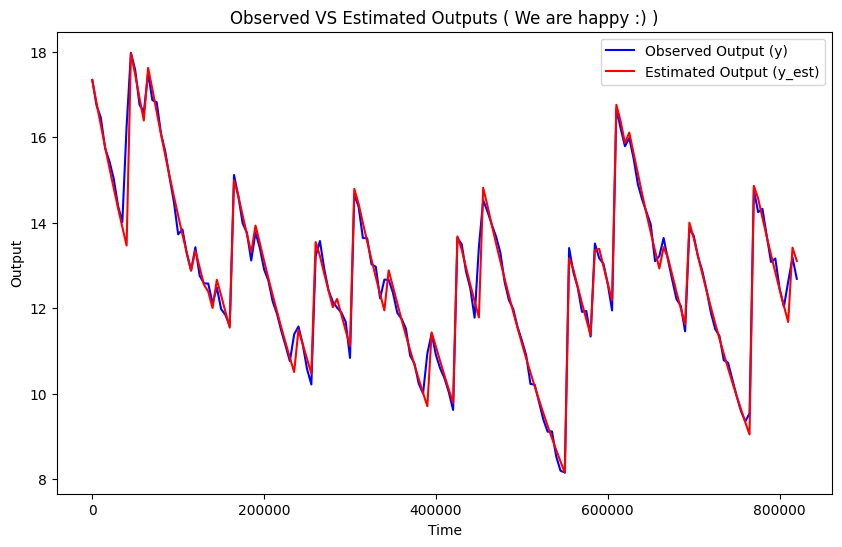

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(ty, y, label='Observed Output (y)', color='b')
plt.plot(ty, y_est, label='Estimated Output (y_est)', color='r')
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('Observed VS Estimated Outputs ( We are happy :) )')
plt.legend()
plt.show()


**And here is the R2 values**

In [77]:
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y, y_est)
print(f'R-squared: {r2}')

R-squared: 0.9719941149367466


# Least square Optmiziation method

**We Solved the problem with another optimization approach, which did not show a considerable difference. Both results and parameter values are similar to those before.**

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0037e+04                                    3.35e+03    
       1              2         1.1887e+03      8.85e+03       1.18e-01       5.04e+03    
       2              3         1.5233e+01      1.17e+03       1.52e-01       4.01e+02    
       3              4         9.4463e+00      5.79e+00       1.15e-01       6.65e+00    
       4              5         9.2760e+00      1.70e-01       6.93e-02       1.06e+00    
       5              6         9.2589e+00      1.71e-02       3.11e-02       2.27e-01    
       6              7         9.2573e+00      1.56e-03       1.10e-02       6.25e-02    
       7              8         9.2572e+00      1.37e-04       3.43e-03       1.80e-02    
       8              9         9.2572e+00      1.20e-05       1.03e-03       2.92e-02    
       9             10         9.2572e+00      1.04e-06       3.05e-04       1.25e-02    

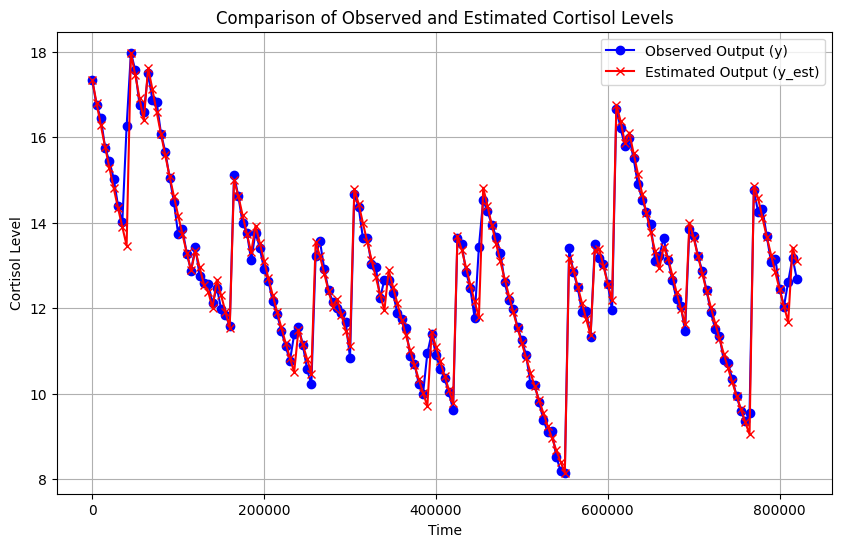

In [79]:
import numpy as np
import scipy.io
from scipy.optimize import least_squares
import matplotlib.pyplot as plt


def DEQ1(u, theta1):
    x1 = np.zeros(len(u))
    for t, u_t in enumerate(u):
        if t < len(x1) - 1:
            x1[t + 1] = x1[t] - theta1 * x1[t] + u_t
    return x1



def DEQ2(y, x1, theta1, theta2):
  x2=np.zeros(len(x1))
  x2[0] = y[0]

  for t in range(1, len(x1)):
    x2[t] = x2[t - 1] + (theta1 * x1[t - 1]) - (theta2 * x2[t - 1])

  return x2



def Estimation(x2, ty, tu):
  y_est = np.interp(ty, tu, x2)

  return y_est

def residuals(params, u, y, tu, ty):
    theta1, theta2 = params
    if theta1 <= 0 or theta2 <= 0:
        return np.inf * np.ones_like(y)
    x1 = DEQ1(u, theta1)
    x2 = DEQ2(y, x1, theta1, theta2)
    y_est = Estimation(x2, ty, tu)
    return y - y_est

def jacobian(params, u, y, tu, ty):
    epsilon = 1e-8
    J = []
    for i in range(len(params)):
        params_eps = np.array(params)
        params_eps[i] += epsilon
        res1 = residuals(params_eps, u, y, tu, ty)
        res0 = residuals(params, u, y, tu, ty)
        J.append((res1 - res0) / epsilon)
    return np.array(J).T

initial_guess = [0.1, 0.05]

# Define bounds for theta1 and theta2
lower_bounds = [1e-6, 1e-6]
upper_bounds = [np.inf, np.inf]

result = least_squares(
    residuals,
    initial_guess,
    args=(u, y, tu, ty),
    bounds=(lower_bounds, upper_bounds),
    method='trf',
    loss='linear',
    verbose=2
)

theta1_est, theta2_est = result.x
print(f'Estimated theta1: {theta1_est:.4f}')
print(f'Estimated theta2: {theta2_est:.4f}')

# Compute estimated output
x1_est = DEQ1(u, theta1_est)
x2_est = DEQ2(y, x1_est, theta1_est, theta2_est)
y_est = Estimation(x2_est, ty, tu)

plt.figure(figsize=(10, 6))
plt.plot(ty, y, label='Observed Output (y)', marker='o', color='b')
plt.plot(ty, y_est, label='Estimated Output (y_est)', marker='x', color='r')
plt.xlabel('Time')
plt.ylabel('Cortisol Level')
plt.title('Comparison of Observed and Estimated Cortisol Levels')
plt.legend()
plt.grid(True)
plt.show()


In [80]:
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y, y_est)
print(f'R-squared: {r2}')

R-squared: 0.9719941149294176
